In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
TWEMOJI_DATASET = './datasets/samples/combined_csv.csv'
EMOJI_MAPPINGS = './datasets/emoji_map_1791.csv'

In [4]:
twemoji = pd.read_csv(TWEMOJI_DATASET)

/Users/frankpalma/Desktop/clasifica-emoji/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
mappings = pd.read_csv(EMOJI_MAPPINGS)

In [5]:
twemoji = twemoji.reindex(np.random.permutation(twemoji.index))

# Mappings

In [28]:
# we can see that we now have the dataframe that contain all 
# the emoji mappings
mappings.head(5) 

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
0,#️⃣,symbols,keycap number sign,[hash],0023-fe0f-20e3,"[keycap, symbol, pound, hash, number]",0023_fe0f_20e3,#️⃣,NaN,NaN,NaN
1,*️⃣,symbols,keycap asterisk,[asterisk],002a-fe0f-20e3,"[keycap, symbol, asterisk, star]",002a_fe0f_20e3,*️⃣,[:keycap_asterisk:],NaN,NaN
2,0️⃣,symbols,keycap digit zero,[zero],0030-fe0f-20e3,"[, keycap, symbol, number, zero, math]",0030_fe0f_20e3,0️⃣,NaN,NaN,NaN
3,1️⃣,symbols,keycap digit one,[one],0031-fe0f-20e3,"[, keycap, symbol, number, one, math]",0031_fe0f_20e3,1️⃣,NaN,NaN,NaN
4,2️⃣,symbols,keycap digit two,[two],0032-fe0f-20e3,"[, keycap, symbol, two, number, math]",0032_fe0f_20e3,2️⃣,NaN,NaN,NaN


# Cleaning and Preparing

In [6]:
# lets see how many columns 
# does the dataset have
twemoji.columns

Index(['id', 'annotations', 'id_text'], dtype='object')

In [7]:
# rename annotations to target
# rename id_text to tweet
twemoji = twemoji.rename(columns={"annotations":'target', "id_text":"tweet"})

In [8]:
twemoji.head() 

,id,target,tweet
2915823,742392886956724224,1381,NaN
3570599,747898647543689216,549,NaN
2602288,748132966228865024,1447,NaN
500174,741880611598565376,1415,NaN
146220,748359089109884928,170,NaN


In [9]:
# since the id column is no longer needed
# we can simply drop it
twemoji = twemoji.drop(columns=["id"])

In [10]:
twemoji.head()

,target,tweet
2915823,1381,NaN
3570599,549,NaN
2602288,1447,NaN
500174,1415,NaN
146220,170,NaN


In [11]:
# Lets check how many null values exist in 
# the dataset
twemoji['tweet'].isna().sum()

3878060

In [12]:
# We can't do much with null values
# So we drop them
twemoji = twemoji.dropna()

In [13]:
twemoji.head()

,target,tweet
1494850,1381,Ever felt excited for no reason ? like you hea...
1619765,1475,Lol... Shall we start a POSITIVE bank account
1743316,1381,The fact that that's about my tuition
1362371,1392,You can call me Monster
1789492,1380,I had my favorites tonight at Kenny Roger's. T...


In [14]:
# Lets check how big is the data set now
twemoji.shape

(88567, 2)

# Exploration

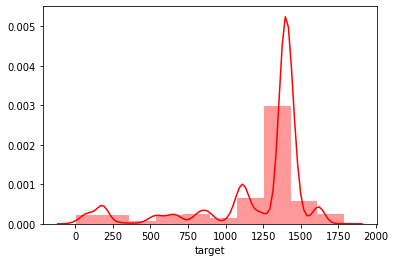

In [15]:
# lets see the distribution of our target values
sns.distplot(twemoji['target'], color='red', bins=10)

In [33]:
most_frequent = twemoji['target'].value_counts().idxmax() 
most_frequent

1381

In [31]:
# The laughing face emoji is the most popular in this dataset
mappings.loc[most_frequent]

Unnamed: 0                                                            😂
category                                                         people
title                                            face with tears of joy
shorts                                                            [joy]
unicode_alternates                                                  NaN
keywords              [emotion, cry, tear, joy, smiley, sarcastic, f...
ucode_short                                                       1f602
ucode                                                                 😂
aliases                                                             NaN
alt_title                                                           NaN
aliases_ascii                                               [:'), :'-)]
Name: 1381, dtype: object

In [36]:
# Lets see the 10 most frequently used emojis
top_ten = twemoji['target'].value_counts()[:10].index.tolist() 
top_ten

[1381, 1447, 1424, 1392, 1389, 186, 1620, 1420, 1446, 1403]

In [37]:
# lets see the mappings
mappings.loc[top_ten]

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
1381,😂,people,face with tears of joy,[joy],NaN,"[emotion, cry, tear, joy, smiley, sarcastic, f...",1f602,😂,NaN,NaN,"[:'), :'-)]"
1447,🙄,people,face with rolling eyes,"[rolling_eyes, face_with_rolling_eyes]",NaN,"[emotion, eyes, rolling eyes, smiley, sarcasti...",1f644,🙄,[:face_with_rolling_eyes:],NaN,NaN
1424,😭,people,loudly crying face,[sob],NaN,"[emotion, sob, tear, cry, smiley, sad, heartbr...",1f62d,😭,NaN,NaN,NaN
1392,😍,people,smiling face with heart shaped eyes,[heart_eyes],NaN,"[emotion, heart, eye, love, smiley, face, beau...",1f60d,😍,NaN,smiling face with heart-shaped eyes,NaN
1389,😊,people,smiling face with smiling eyes,[blush],NaN,"[emotion, beautiful, good, eye, smiley, face, ...",1f60a,😊,NaN,NaN,NaN
186,❤,symbols,heavy black heart,[heart],2764-fe0f,"[heart, symbol, love, parties]",2764,❤,NaN,NaN,[<3]
1620,🤔,people,thinking face,"[thinking, thinking_face]",NaN,"[thinking, boys night, smiley, face]",1f914,🤔,[:thinking_face:],NaN,NaN
1420,😩,people,weary face,[weary],NaN,"[emotion, tired, face, smiley, sad, stressed, ...",1f629,😩,NaN,NaN,NaN
1446,🙃,people,upside down face,"[upside_down_face, upside_down]",NaN,"[smiley, silly, upside down, sarcastic, face]",1f643,🙃,[:upside_down_face:],upside-down face,NaN
1403,😘,people,face throwing a kiss,[kissing_heart],NaN,"[heart, love, smiley, face, kiss, sexy]",1f618,😘,NaN,NaN,"[:*, :-*, =*, :^*]"


In [46]:
# We see that there is a high density around 1000-1500
# lets reduce the number of emojis there exists to the
# top 10 emojis that exists in the dataset
# we could reduce the complexity of our problem. 
index_names = twemoji[~twemoji['target'].isin(top_ten)].index
twemoji = twemoji.drop(index_names)

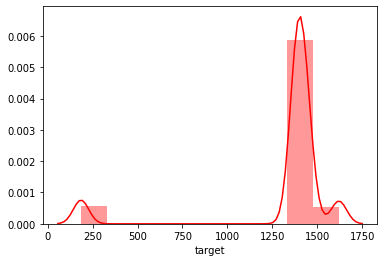

In [47]:
# lets see the distribution once again
sns.distplot(twemoji['target'], color='red', bins=10)

In [49]:
# For sanity check lets see if the remaining emojis
# are only the top ten emojis
twemoji['target'].value_counts().index.tolist() 

[1381, 1447, 1424, 1392, 1389, 186, 1620, 1420, 1446, 1403]

## Bag-Of-Words Model

`Bag of words` allows us to represent text as numberical feature vectors. 
This idea behind the bag of words model can be summarized as follows

1. Create a vocabulary of unique tokens, for example words, from the entire set of documents
2. Concstruct a feature vector from each document that contains the counts of how often wach word occurs
    in the particular document
    
Unique words in documents represent only a small subset of all words in the `bag of words` vocabulary, therfore the feature vectors will mostly consist of zeros, which is why we call them `sparse`
